# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.special import logsumexp
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from sklearn import metrics
from skimage.color import rgb2gray
import copy

# 1. Load data

In [2]:
cifarBase = "cifar-10-batches-py"
cifarTrainName = "data_batch_"
cifarSize = 1024
fashion_label_desc = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
cifar_label_desc = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

    
def readCifarData():
    cifarTest = unpickle(cifarBase + "/" + "test_batch")
    cifarTrain = [unpickle(cifarBase + "/" + cifarTrainName + str(i)) for i in range(1,6)]
    cifarTestLabels = cifarTest[b'labels']
    cifarTestData = cifarTest[b'data']
    cifarTrainLabels = np.concatenate([batch[b'labels'] for batch in cifarTrain])
                                      
    cifarTrainData = np.concatenate([batch[b'data'] for batch in cifarTrain])
    cifarTrainData = np.dstack((cifarTrainData[:, :1024], cifarTrainData[:, 1024:2048], cifarTrainData[:, 2048:]))
    
    cifarTrainData = cifarTrainData.reshape(-1,1024, 3)
    
    cifarTestData = np.dstack((cifarTestData[:, :1024], cifarTestData[:, 1024:2048], cifarTestData[:, 2048:]))
    cifarTestData = cifarTestData.reshape(-1,1024, 3)

    return cifarTrainLabels,cifarTrainData,cifarTestLabels,cifarTestData

In [3]:
fashionTest = pd.read_csv("fashion-mnist_test.csv")
fashionTrain = pd.read_csv("fashion-mnist_train.csv")
cifarTrainLabels,cifarTrainData,cifarTestLabels,cifarTestData = readCifarData()
grayCifarTrainData = rgb2gray(cifarTrainData)
grayCifarTestData = rgb2gray(cifarTestData)

In [4]:
print(fashionTrain.shape)
print(fashionTest.shape)
print(grayCifarTrainData.shape)
print(grayCifarTestData.shape)

(60000, 785)
(10000, 785)
(50000, 1024)
(10000, 1024)


In [5]:
y_fashion = fashionTrain.label.values
X_fashion = fashionTrain.drop("label",axis=1)
y_fashion_test = fashionTest.label.values
X_fashion_test = fashionTest.drop("label",axis=1)

y_cifar = cifarTrainLabels
X_cifar = pd.DataFrame(data=grayCifarTrainData)
y_cifar_test = cifarTestLabels
X_cifar_test = pd.DataFrame(data=grayCifarTestData)

# 2. Comment data

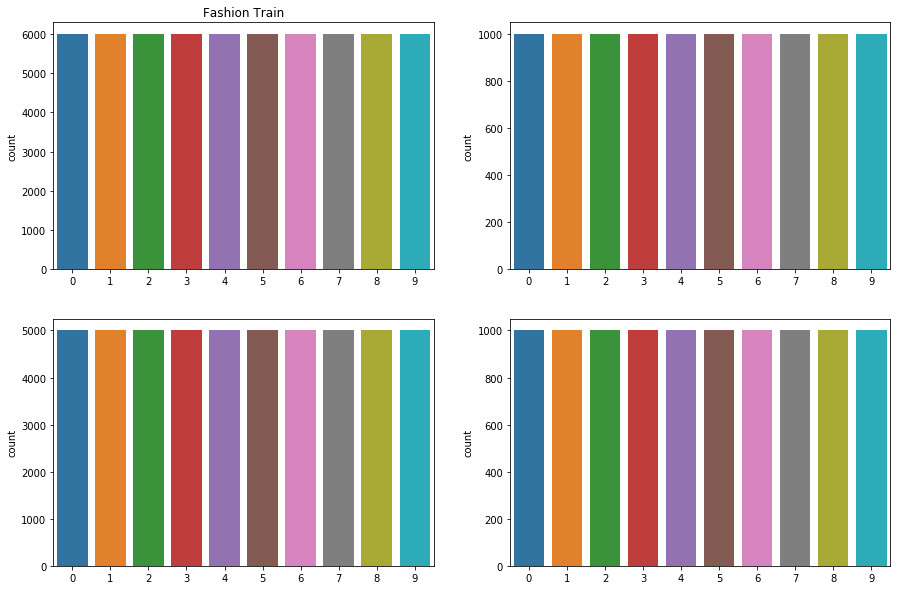

In [6]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.title("Fashion Train")
sns.countplot(y_fashion)
plt.subplot(222)
sns.countplot(y_fashion_test)
plt.subplot(223)
sns.countplot(y_cifar)
plt.subplot(224)
sns.countplot(y_cifar_test)
plt.show()

# 3. Classification

In [7]:
class NaiveBayesClassifier(object):
    def calcLogLikelihood(self,X,mean,var):
        return mvn.logpdf(X, mean=mean, cov=var)
        
    def fit(self,X,Y):
        X = copy.deepcopy(X)
        X["label"] = Y
        self.labels = sorted(X["label"].unique())
        self.mean = X.groupby("label").mean()
        self.var = X.groupby("label").var()
    
    def likelihood(self,x,t):
        mean = self.mean.loc[t].values
        var = self.var.loc[t].values + 1e-2
        log_likelihood = self.calcLogLikelihood(x,mean,var)
        return log_likelihood
    
    def prior(self):
        return 1 / len(self.labels)
    
    def posterior(self,x,t):
        return self.likelihood(x,t) + np.log( self.prior())
    
    def predict(self,X):
        p = np.array([self.posterior(X,t) for t in self.labels]).T
        return p.argmax(axis=1)
    
    def score(self,X,y):
        preds = self.predict(X)
        return np.mean(preds == y)          

In [9]:
classifier = NaiveBayesClassifier()
classifier.fit(X_fashion,y_fashion)
print(classifier.score(X_fashion_test,y_fashion_test))

0.6125


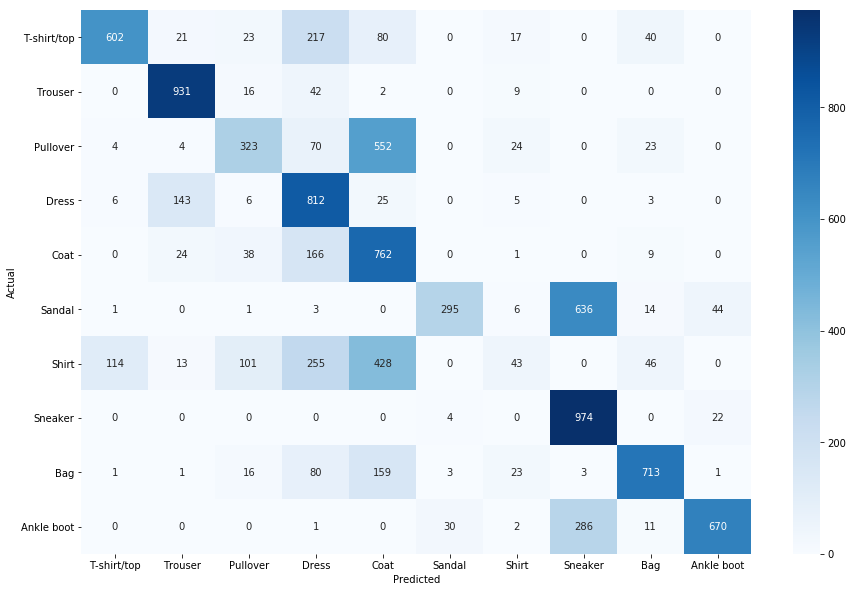

In [10]:
cf = np.zeros((10,10))
for pred,t in zip(classifier.predict(X_fashion_test),y_fashion_test):
    cf[t][pred] += 1
plt.figure(figsize=(15,10))

df = pd.DataFrame(data=cf.astype(int),columns=fashion_label_desc)
df.index = fashion_label_desc

sns.heatmap(df,annot=True, fmt="d",cmap="Blues")
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [11]:
classifier = NaiveBayesClassifier()
classifier.fit(X_cifar,y_cifar)
print(classifier.score(X_cifar_test,y_cifar_test))

0.2554


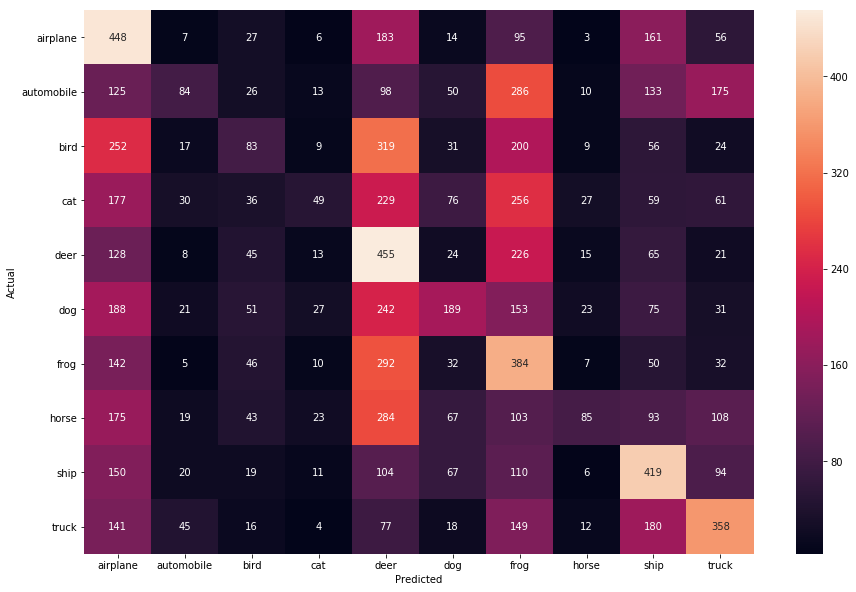

In [12]:
cf = np.zeros((10,10))
for pred,t in zip(classifier.predict(X_cifar_test),y_cifar_test):
    cf[t][pred] += 1
plt.figure(figsize=(15,10))

df = pd.DataFrame(data=cf.astype(int),columns=cifar_label_desc)
df.index = cifar_label_desc

sns.heatmap(df,annot=True, fmt="d",cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation=0) 
plt.show()

## 3.2 Random Classifier

In [13]:
class RandomClassifier(object):
    def predict(self,X):
        return np.random.random_integers(low=0,high=9,size=len(X))
    
    def score(self,X,y):
        preds = self.predict(X)
        return np.mean(preds == y)

In [14]:
classifier = RandomClassifier()
print(classifier.score(X_cifar_test,y_cifar_test))

0.1007


/home/marius/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


# 4. Linear Regression

In [15]:
class LinearRegressor(object):
    def findLabel(self,x):
        if (x < 0):
            return 0
        elif(x > 9):
            return 9
        return np.rint(x)
    
    def var(self,X,y):
        return 1/(X.shape[0]-X.shape[1])
        
    def predStd(self,X):
        None
    def prior(self,X):
        return np.identity(X.shape[1])
    
    def fit(self,X,y):
        X = copy.deepcopy(X)
        X = np.insert(X.values,0,1,axis=1)
        self.var = np.var(X,axis=0)
        self.sigma2 = np.var(X)
        pr = self.var * self.prior(X)
        inv = np.linalg.inv(X.T.dot(X) + pr)
        self.mean = inv.dot(X.T).dot(y)
        self.cov = self.var * inv
        
    def predict(self,X):
        X = np.insert(X.values,0,1,axis=1)
        preds = X.dot(self.mean.reshape(-1,1))
        pred_std = self.sigma2 * X.dot(self.cov).dot(X.T).diagonal()
        return preds,pred_std
    
        
    def score(self,X,y):
        preds,_ = self.predict(X)
        preds = list(map(self.findLabel, preds.ravel()))
        return np.mean(preds == y)

### Fashion MNIST

In [16]:
linearRegressor = LinearRegressor()
linearRegressor.fit(X_fashion,y_fashion)

In [17]:
linearRegressor.score(X_fashion_test,y_fashion_test)

0.3919

Mean square error = 14.689980012886867


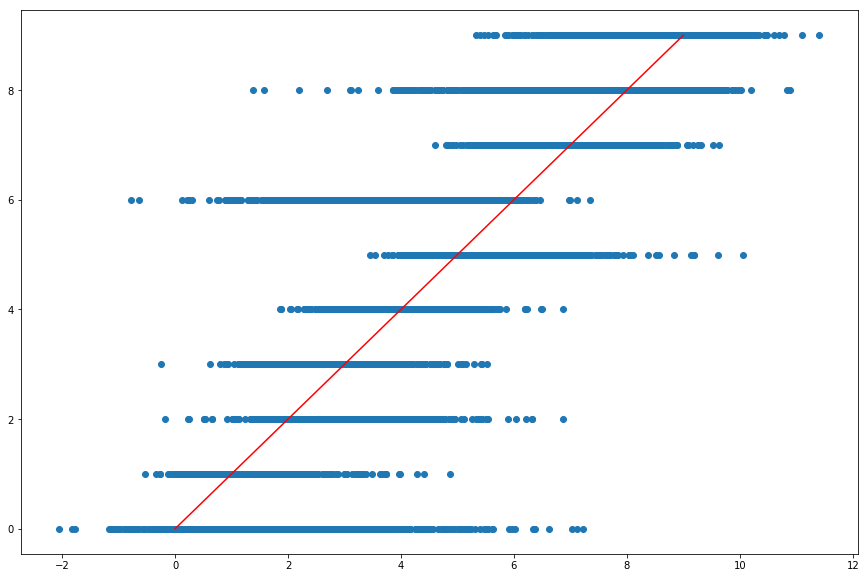

In [18]:
pred,std = linearRegressor.predict(X_fashion_test)

plt.figure(figsize=(15,10))
plt.scatter(pred,y_fashion_test)
plt.plot([0,9],[0,9],"r")
plt.show

mse = np.mean(np.power(pred - y_fashion_test,2))
print("Mean square error =",mse)

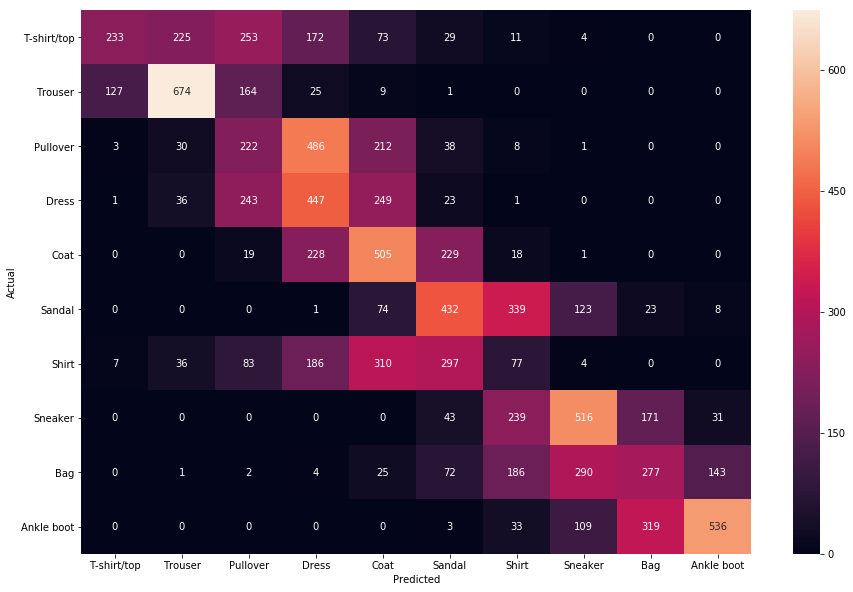

In [19]:
preds,std = linearRegressor.predict(X_fashion_test)
preds_labeled = list(map(linearRegressor.findLabel, preds.ravel()))

cf = np.zeros((10,10))
for pred,t in zip(preds_labeled,y_fashion_test):
    cf[t][int(pred)] += 1
plt.figure(figsize=(15,10))

df = pd.DataFrame(data=cf.astype(int),columns=fashion_label_desc)
df.index = fashion_label_desc

sns.heatmap(df,annot=True, fmt="d")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation=0) 
plt.show()

### Cifar10 

In [20]:
linearRegressor = LinearRegressor()
linearRegressor.fit(X_cifar,y_cifar)

In [21]:
linearRegressor.score(X_cifar_test,y_cifar_test)

0.0

Mean square error = 8.832569112171445


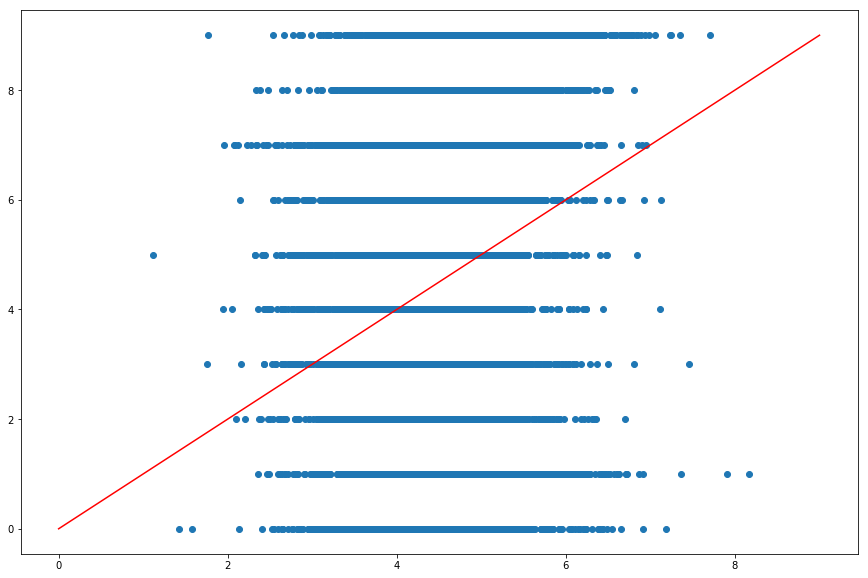

In [22]:
pred,std = linearRegressor.predict(X_cifar_test)

plt.figure(figsize=(15,10))
plt.scatter(pred,y_cifar_test)
plt.plot([0,9],[0,9],"r")
plt.show

mse = np.mean(np.power(pred - y_cifar_test,2))
print("Mean square error =",mse)

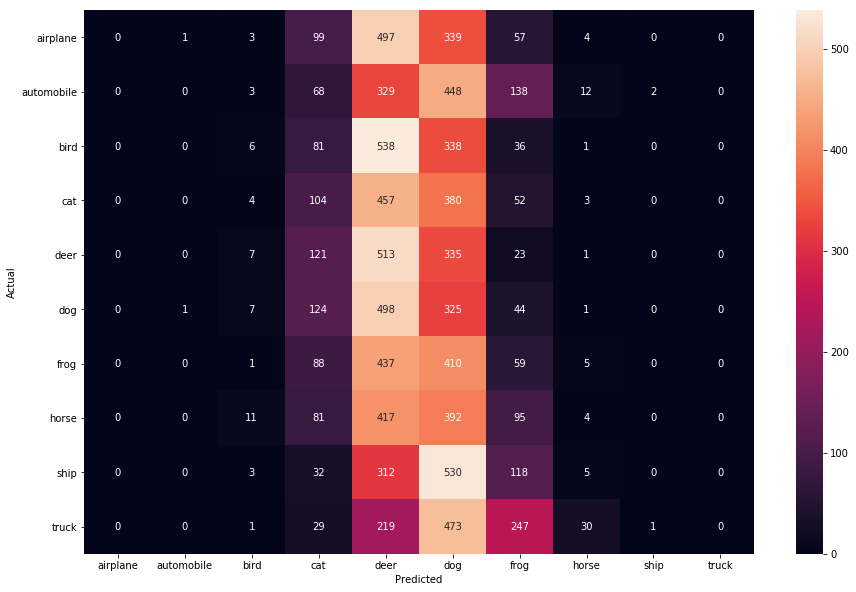

In [23]:
preds,std = linearRegressor.predict(X_cifar_test)
preds_labeled = list(map(linearRegressor.findLabel, preds.ravel()))

cf = np.zeros((10,10))
for pred,t in zip(preds_labeled,y_cifar_test):
    cf[t][int(pred)] += 1
plt.figure(figsize=(15,10))

df = pd.DataFrame(data=cf.astype(int),columns=cifar_label_desc)
df.index = cifar_label_desc

sns.heatmap(df,annot=True, fmt="d")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation=0) 
plt.show()

# Bayesion logistic regression

# CNN